# Gradient Descent for Linear Regression

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
class LinearRegression:
    
    def __init__(self, X, y, regularization, regularization_rate, tolerance,
                 learninig_rate, max_itr, optimizer,  batch) -> None:
        self.X = X
        self.y = y
        self.regularization = regularization
        self.regularization_rate = regularization_rate
        self.tolerance = tolerance
        self.learninig_rate = learninig_rate
        self.max_itr = max_itr
        self.optimizer = optimizer
        self.batch = batch
        
        if (self.regularization == False):
            selfregularization_rate = 0
        
    def split_data(self):       
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                           test_size =0.3,
                                                           shuffle = True)
        return X_train, X_test, y_train, y_test
    
    def add_X0(self, X):
        num_samples, num_features = X.shape
        ones_column = np.ones((num_samples, 1))
        return np.column_stack([ones_column, X])

    
    
    def normalize_train(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X = (X - mean)/ std
        X = self.add_X0(X)
        return X, mean, std
    
    def normalize_test(self, X, mean, std):
        X = (X - mean)/std
        X = self.add_X0(X)
        return X
    
    def rank(self, X):
        u, s, v = np.linalg.svd(X)
        rank = sum([1 for s_ in s if s_ > 0.00001])
        return rank
    
    def check_fullRank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
            self.fullRank = True
            print("Matrix is full rank")
        else:
            self.fullRank = False
            print("Matrix is not full rank")
    
    def check_lowRank(self,X):
        if X.shape[1] > X.shape[0]:
            self.lowRank = True
            print("Matrix is low rank")
        else:
            self.lowRank = False
            print("Matrix is not low rank")
    
    def normal_equation(self, X, y):
        self.theta = np.linalg.inv((X.T.dot(X))+(self.regularization_rate * 
                                                 np.identity(X.shape[1]))).dot(X.T).dot(y)

        return self.theta
        
    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y)**2).sum()
    
    def rmse(self, X, y):
        return np.sqrt((self.sse(X, y)) / X.shape[0])
    
    
    def fit(self):
        
        X_train, X_test, y_train, y_test = self.split_data()
        X_train ,mean ,std = self.normalize_train(X_train)
        X_test = self.normalize_test(X_test, mean, std)
                
        self.check_fullRank(X_train)
        self.check_lowRank(X_train)
        
        
        if (self.optimizer=='Normal' and self.fullRank and not self.lowRank and X_train.shape[0] < 10000):
            print("Closed Form Solution")
            self.theta = self.normal_equation(X_train, y_train)
            
        elif self.optimizer == 'GD':
            print('Gradient Descent')
            self.theta = np.ones(X_train.shape[1], dtype = np.float16)*0
            self.gradientDescent(X_train, y_train)

        elif self.optimizer == 'SGD':
            print('Stochastic Gradient Descent')
            self.theta = np.ones(X_train.shape[1], dtype = np.float16)*0
            self.stochasticGradientDescent(X_train, y_train)

        print(self.theta)
        print('SSE:', self.sse(X_test, y_test))
        print('RMSE:', self.rmse(X_test, y_test))
        
        
    def predict(self, X): 
        return X.dot(self.theta)
    
    def costFunction(self, X, y):
        return self.sse(X,y) / 2
    
    def cost_derivation(self, X, y): 
        y_hat = self.predict(X)
        return X.T.dot(y_hat - y)  
        
    def gradientDescent(self, X, y):
        errors = []
        last_error =  float('inf')
        for i in tqdm(range(self.max_itr)):
            self.theta = self.theta - self.learninig_rate * (self.cost_derivation(X, y) 
                                                   + (self.regularization_rate * self.theta))
            current_error = self.sse(X,y)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)
            if diff < self.tolerance:        
                print('Model has stopped learning')
                break
        self.plot_rmse(errors)
        
    def stochasticGradientDescent(self, X, y):
        errors = []
        last_error = float('inf')

        for i in tqdm(range(self.max_itr)):
            index = np.arange(X.shape[0])
            np.random.shuffle(index)
            X = X[index]
            y = y[index]
            X = X[0:self.batch]
            y = y[0:self.batch]
            self.theta = self.theta - self.learninig_rate * (self.cost_derivation(X, y) + 
                                                             (self.regularization_rate * self.theta))
            current_error = self.sse(X,y)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)
            if diff < self.tolerance:        
                print('Model has stopped learning')
                break
        self.plot_rmse(errors)
        
    def plot_rmse(self, error_sequence):
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)
        ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.xlabel('iterations')
        plt.ylabel('Cost Function')
        plt.show()

# Housing Data
### Housing: learning rate = 0.4 × 10^−3, tolerance = 0.5 × 10^−2

In [3]:
housing_data = pd.read_csv('housing.csv')

### Normal Equation

In [4]:
regression = LinearRegression(X = housing_data.values[:, 0:-1], y = housing_data.values[:, -1],
                              regularization = True, regularization_rate = 1, tolerance=0,
                             learninig_rate=0.0004, max_itr=50000, optimizer = 'Normal', batch = 0)

In [5]:
regression.fit()

Matrix is full rank
Matrix is not low rank
Closed Form Solution
[22.61327684 -1.04755342  0.90178723  0.50120912  0.78852118 -1.88046166
  2.51635521  0.13286728 -2.84204526  2.55566462 -1.93752323 -2.23712244
  0.94100943 -4.31365738]
SSE: 3037.6426326560218
RMSE: 4.470401660289143


### Gradient Descent

In [6]:
regression = LinearRegression(X = housing_data.values[:, 0:-1], y = housing_data.values[:, -1],
                              regularization = True, regularization_rate=1, tolerance=0.005,
                              learninig_rate=0.0004, max_itr=50000, optimizer = 'GD', batch=100)

Matrix is full rank
Matrix is not low rank
Gradient Descent


  1%|▎                                   | 404/50000 [00:00<00:00, 50773.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


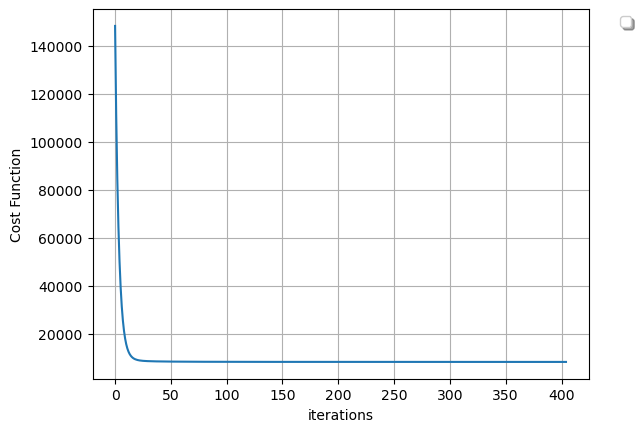

[22.43050847 -1.01297958  1.12052835 -0.50134935  0.71759208 -1.73867182
  2.23106633  0.45758701 -3.07311195  2.49818263 -1.54066371 -2.02907125
  0.80266207 -4.28587406]
SSE: 2926.563061368037
RMSE: 4.387904323376423


In [7]:
regression.fit()

### Stochastic Gradient Descent

In [8]:
regression = LinearRegression(X = housing_data.values[:, 0:-1], y = housing_data.values[:, -1],
                              regularization = True, regularization_rate=1, tolerance=0.005,
                              learninig_rate=0.0004, max_itr=50000, optimizer = 'SGD', batch=100)

Matrix is full rank
Matrix is not low rank
Stochastic Gradient Descent


  1%|▌                                   | 732/50000 [00:00<00:01, 47965.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


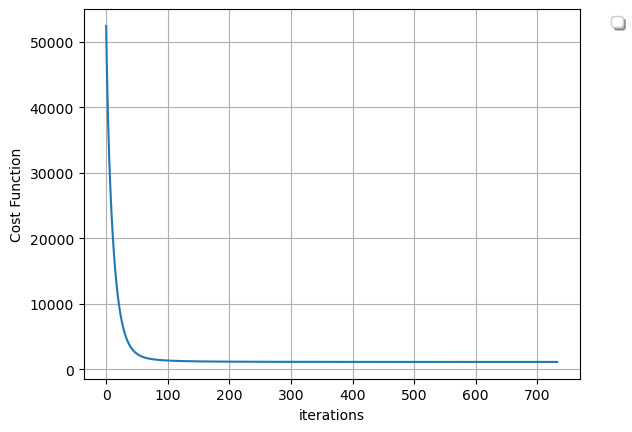

[22.25897831 -1.26985503  0.33994597 -0.35378174  0.71039104 -0.52681423
  3.7171204  -0.21697268 -0.95979589  1.32063096 -0.14501654 -1.42863461
 -0.54394865 -3.30565373]
SSE: 5197.648621685425
RMSE: 5.8476539502277864


In [9]:
regression.fit()

# Yatcht Data
### Yacht: learning rate = 0.1 × 10^−2, tolerance = 0.1 × 10^−2

In [10]:
yatcht_data = pd.read_csv('yachtData.csv')

### Normal Equation

In [11]:
regression = LinearRegression(X = yatcht_data.values[:, 0:-1], y = yatcht_data.values[:, -1],
                              regularization = True, regularization_rate = 1, tolerance=0.001,
                             learninig_rate=0.001, max_itr=50000, optimizer = 'Normal', batch = 0)

In [12]:
regression.fit()

Matrix is full rank
Matrix is not low rank
Closed Form Solution
[10.76344186  0.33152355 -0.02107402 -0.28887464 -0.59257728 -0.14705395
 12.41400564]
SSE: 8291.726111311644
RMSE: 9.442369685779143


### Gradient Descent

In [13]:
regression = LinearRegression(X = yatcht_data.values[:, 0:-1], y = yatcht_data.values[:, -1],
                              regularization = True, regularization_rate=1, tolerance=0.001,
                              learninig_rate=0.001, max_itr=50000, optimizer = 'GD', batch=100)

Matrix is full rank
Matrix is not low rank
Gradient Descent


  2%|▊                                  | 1142/50000 [00:00<00:00, 58878.64it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


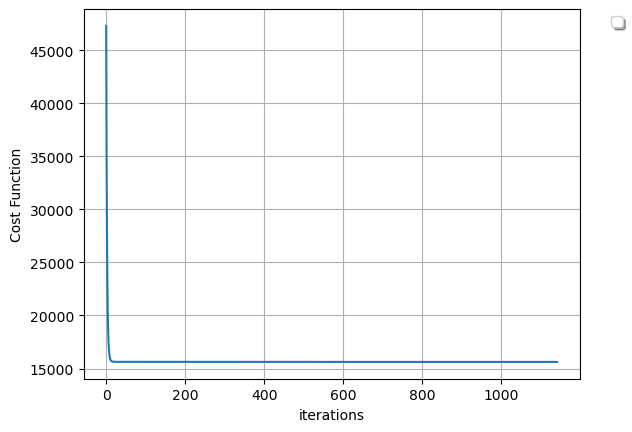

[10.04488372 -0.13296524 -0.28178102  0.97319185 -1.08694676 -0.9570853
 11.65449108]
SSE: 8642.776265107848
RMSE: 9.640180398697902


In [14]:
regression.fit()

### Stochastic Gradient Descent

In [15]:
regression = LinearRegression(X = yatcht_data.values[:, 0:-1], y = yatcht_data.values[:, -1],
                              learninig_rate=0.001, max_itr=50000, tolerance=0.001,  regularization = True, 
                              regularization_rate=1, batch=100, optimizer = 'SGD')

Matrix is full rank
Matrix is not low rank
Stochastic Gradient Descent


  5%|█▋                                 | 2331/50000 [00:00<00:01, 46425.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


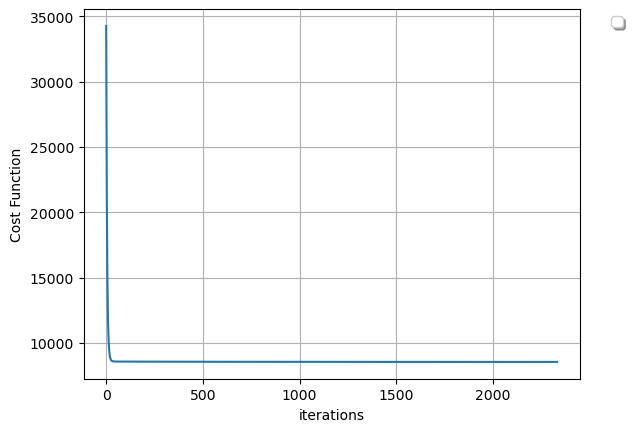

[10.65129631  1.26470782 -0.73874055 -2.53988309  1.05129908  2.01084781
 13.40267888]
SSE: 6888.521651632013
RMSE: 8.606400251345839


In [16]:
regression.fit()

# Concrete Data
### Concrete: learning rate = 0.7 × 10^−3, tolerance = 0.1 × 10^−3

In [17]:
concrete_data = pd.read_csv('concreteData.csv')

### Normal Equation

In [18]:
regression = LinearRegression(X = concrete_data.values[:, 0:-1], y = concrete_data.values[:, -1],
                              regularization = True, regularization_rate = 1, tolerance=0.0001,
                             learninig_rate=0.0007, max_itr=50000, optimizer = 'Normal', batch = 0)

In [19]:
regression.fit()

Matrix is full rank
Matrix is not low rank
Closed Form Solution
[35.47819695 12.74717157  9.34732788  5.86355493 -3.0080292   1.73997014
  1.25616651  1.80251309  6.62153396]
SSE: 33451.21908614263
RMSE: 10.404632259098037


### Gradient Descent

In [20]:
regression = LinearRegression(X = concrete_data.values[:, 0:-1], y = concrete_data.values[:, -1],
                              regularization = True, regularization_rate = 1, tolerance=0.0001,
                             learninig_rate=0.0007, max_itr=50000, optimizer = 'GD', batch = 0)

Matrix is full rank
Matrix is not low rank
Gradient Descent


  1%|▌                                   | 705/50000 [00:00<00:02, 22600.00it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


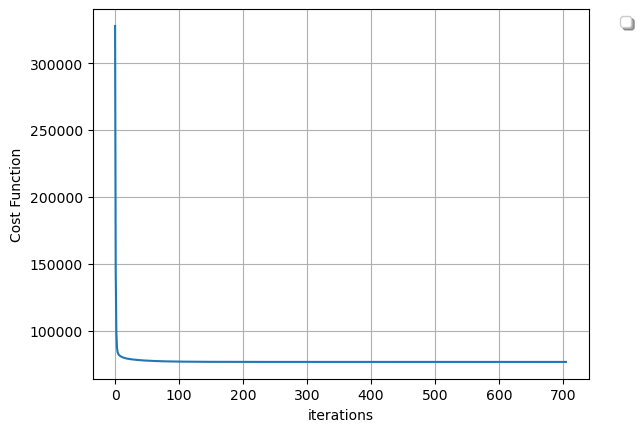

[35.35185853 13.32171273  9.42838838  6.12179943 -2.75373484  1.74095551
  2.06247036  2.54892342  6.77050372]
SSE: 33536.57767816615
RMSE: 10.417898725040375


In [21]:
regression.fit()

### Stochastic Gradient Descent

In [22]:
regression = LinearRegression(X = concrete_data.values[:, 0:-1], y = concrete_data.values[:, -1],
                              regularization = True, regularization_rate = 1, tolerance=0.0001,
                             learninig_rate=0.0007, max_itr=50000, optimizer = 'SGD', batch = 100)

Matrix is full rank
Matrix is not low rank
Stochastic Gradient Descent


  8%|██▊                                | 3941/50000 [00:00<00:01, 39676.99it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


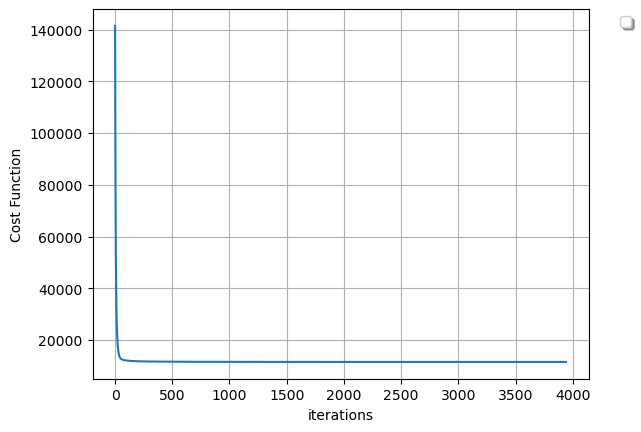

[34.69311936 12.68487611  8.88959103  5.81658695 -5.43888608  0.92510232
  1.71804189  1.19538311  5.85285301]
SSE: 35702.381077508864
RMSE: 10.749031878963805


In [23]:
regression.fit()

#### Obesrvations:
Adding regularization helps reduce the error, leading to more reliable results. Additionally, the choice between Normal Equation, Gradient Descent, and Stochastic Gradient Descent affects the cost function, as each method has different strengths and weaknesses in finding the optimal solution.

| Dataset | Method                  | RMSE           | SSE          |
|---------|-------------------------|----------------|--------------|
| Housing | Closed Room Solution    | 4.47           | 3037.64      |
|         | Gradient Descent (GD)   | 4.38           | 2926.56      |
|         | Stochastic GD (SGD)     | 5.84           | 5197.64      |
|         |                         |                |              |
| Yatcht  | Closed Room Solution    | 9.44           | 8291.72      |
|         | Gradient Descent (GD)   | 9.64           | 8642.77      |
|         | Stochastic GD (SGD)     | 8.60           | 6888.52      |
|         |                         |                |              |
| Concrete| Closed Room Solution    | 10.40          | 33451.21     |
|         | Gradient Descent (GD)   | 10.41          | 33536.57     |
|         | Stochastic GD (SGD)     | 10.74          | 35702.38     |




In both Gradient Descent (GD) and Stochastic Gradient Descent (SGD), the graphs indicate that a high learning rate allows the cost function to converge quickly, requiring fewer iterations. However, this rapid convergence often leads to a higher final cost, as it overshoots the optimal value of theta. Therefore, it's crucial to fine-tune the learning rate (alpha) to achieve the best balance between speed of convergence and accuracy.
